In [5]:
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
import os

os.environ["LANGCHAIN_PROJECT"] = "langgraph-chatbot"

In [7]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

llm = ChatOllama(model='llama3.2')
# llm = ChatGroq(model="llama-3.2-90b-vision-preview")

In [8]:
# Nodes

from pydantic import BaseModel
from typing import List
from langchain_core.messages import SystemMessage

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passesd into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool.
"""

def get_messages_info(messages):
  return [SystemMessage(content=template)] + messages

class PromptInstructions(BaseModel):
  """Instructions on how to prompt the LLM"""
  
  objective: str
  variables: list[str]
  constraints: list[str]
  requirements: list[str]

prompt_req_tools = [PromptInstructions]
# llm_with_tool = llm.bind_tools(prompt_req_tools)
llm_with_structure = llm.with_structured_output(PromptInstructions)

def info_chain(state):
  messages = get_messages_info(state['messages'])
  response = llm_with_structure.invoke(messages)
  return {
    'messages': response
  }


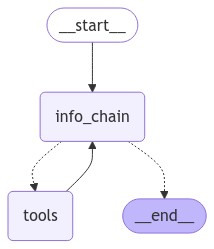

In [9]:
# Test
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)
builder.add_node(info_chain)
builder.add_node(ToolNode(prompt_req_tools))

builder.add_edge(START, 'info_chain')
builder.add_conditional_edges('info_chain', tools_condition)
builder.add_edge('tools', "info_chain")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [10]:
# from langchain_core.messages import HumanMessage
# config = {'configurable': {'thread_id' : 1}}

# msg = "Generate prompt that will help me cook a french dish. Ask at least once more to clarify"

# state = {
#   'messages': [HumanMessage(msg)]
# }

# res = graph.invoke(state, config=config)

In [11]:
# res['messages'][0]

In [12]:

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage, AnyMessage

prompt_system = """Based on the following requirements, write a good prompt template: 

{reqs}"""

def get_prompt_messages(messages):
  tool_call = None  # This is to get the arguments?
  other_msgs = [] # What the fuck is this doing here? Getting the first message after the tool call that is not a tool message?
  for m in messages:
    print(m)
    print('---' * 25)
    if isinstance(m, AIMessage) and m.tool_calls:
      tool_call = m.tool_calls[0]['args']
    elif isinstance(m, ToolMessage):
      continue  
    elif tool_call is not None:
      other_msgs.append(m)
  return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
  messages = get_prompt_messages(state['messages'])
  response = llm.invoke(messages)
  return {
    "messages": [response]
  }

In [13]:
def get_state(state):
  messages = state['messages']
  if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
    return "add_tool_message"
  elif not isinstance(messages[-1], HumanMessage):
    return "__end__"
  return "info"

# How to get human information again? inthe middle of the execution?

In [14]:
def add_tool_message(state):
  return {
    
    # Why add toolmessage again?
    "messages": [
      ToolMessage(content="Prompt generated!", tool_call_id=state['messages'][-1].tool_calls[0]['id'])
    ]
  }

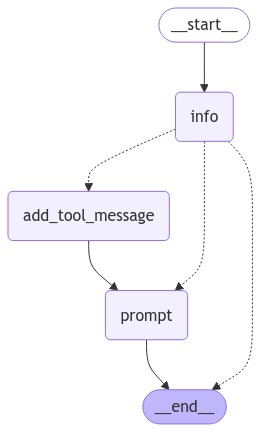

In [15]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import add_messages, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]
  
builder = StateGraph(State)

builder.add_node("info", info_chain)
builder.add_node("prompt", prompt_gen_chain)
builder.add_node(add_tool_message)

builder.add_edge(START, "info")
builder.add_conditional_edges("info", get_state)
builder.add_edge("add_tool_message", "prompt")
builder.add_edge("prompt", END)

graph = builder.compile(MemorySaver())

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [16]:
cached_human_responses = ["hi!", "rag prompt,", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0

config = {'configurable': {"thread_id": 1}}

while True:
  try:
    user = input("User (q/Q to quit): ")
  except:
    user = cached_human_responses[cached_response_index]
    cached_response_index += 1
  print(f"User (q/Q to quit): {user}")
  if user in {"q", "Q"}:
    print("AI: Byebye")
    break
  output = None
  for output in graph.stream(
    {"messages": [HumanMessage(content=user)]},
    config=config,
    stream_mode="values"
  ):
    output['messages'][-1].pretty_print()
    
  if output and "prompt" in output:
    print("Done!")

User (q/Q to quit): write me a joke
================================ Human Message =================================

write me a joke


ValidationError: 3 validation errors for PromptInstructions
variables
  Input should be a valid list [type=list_type, input_value='[]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type
constraints
  Input should be a valid list [type=list_type, input_value='[]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type
requirements
  Input should be a valid list [type=list_type, input_value='["humorous"]', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type